In [1]:
import jax.numpy as jnp
import numpy as np
import os
from jax import jit
from functools import partial
import matplotlib.pyplot as plt

import appletree as apt
from appletree import flex
from appletree import ipm
from appletree import imm
from appletree.flex import randgen
from appletree.flex.plugin import *

In [2]:
apt.utils.set_gpu_memory_usage(0.2)
par_manager = ipm.ParManager('./appletree/ipm/par_config/par_config.json')
map_manager = imm.MapManager()

In [3]:
par_manager.sample_init()
par_manager.get_all_parameter()

{'w': 0.013743155132308407,
 'fano': 0.059,
 'gas_gain': 31.3,
 'drift_velocity': 0.0677,
 's2_threshold': 500.0,
 'field': 23.0,
 'nex_ni_ratio': 0.1008496884964474,
 'g1': 0.15040206336513565,
 'g2': 16.28290270931527,
 'p_dpe': 0.2071702679761973,
 'py0': 0.11606700902750203,
 'py1': 43.22570168775463,
 'py2': -0.38062444317419664,
 'py3': 1.1540386496465336,
 'py4': 0.6403657603474471,
 'rf0': 0.026584824767048307,
 'rf1': 0.23675360853961405}

In [4]:
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's1_correction_map_regbin.json'), coord_type='regbin', map_name='s1_lce')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's2_correction_map_regbin.json'), coord_type='regbin', map_name='s2_lce')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 'elife.json'), coord_type='point', map_name='elife')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's1_bias.json'), coord_type='point', map_name='s1_bias')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's1_smearing.json'), coord_type='point', map_name='s1_smear')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's2_bias.json'), coord_type='point', map_name='s2_bias')
map_manager.register_json_map(os.path.join(imm.DATAPATH, 's2_smearing.json'), coord_type='point', map_name='s2_smear')
map_manager.register_json_map(os.path.join(imm.DATAPATH, '3fold_recon_eff.json'), coord_type='point', map_name='s1_eff')

In [5]:
map_manager.registration

{'s1_lce': '/home/zihaoxu/appletree/appletree/imm/data/s1_correction_map_regbin.json',
 's2_lce': '/home/zihaoxu/appletree/appletree/imm/data/s2_correction_map_regbin.json',
 'elife': '/home/zihaoxu/appletree/appletree/imm/data/elife.json',
 's1_bias': '/home/zihaoxu/appletree/appletree/imm/data/s1_bias.json',
 's1_smear': '/home/zihaoxu/appletree/appletree/imm/data/s1_smearing.json',
 's2_bias': '/home/zihaoxu/appletree/appletree/imm/data/s2_bias.json',
 's2_smear': '/home/zihaoxu/appletree/appletree/imm/data/s2_smearing.json',
 's1_eff': '/home/zihaoxu/appletree/appletree/imm/data/3fold_recon_eff.json'}

In [6]:
args = (par_manager, map_manager)

#### Microphysics plugins

In [7]:
plugin1 = EnergySpectra(*args)
plugin2 = Quenching(*args)
plugin3 = Ionization(*args)
plugin4 = mTI(*args)
plugin5 = RecombFluct(*args)
plugin6 = TrueRecomb(*args)
plugin7 = Recombination(*args)

#### Detector plugins

In [8]:
plugin8 = PositionSpectra(*args)
plugin9 = S1Correction(*args)
plugin10 = S2Correction(*args)
plugin11 = PhotonDetection(*args)
plugin12 = S1PE(*args)
plugin13 = DriftLoss(*args)
plugin14 = ElectronDrifted(*args)
plugin15 = S2PE(*args)

#### Reconstruction plugins

In [9]:
plugin16 = S1(*args)
plugin17 = S2(*args)
plugin18 = cS1(*args)
plugin19 = cS2(*args)

#### Efficiency plugins

In [10]:
plugin20 = S2Threshold(*args)
plugin21 = S1ReconEff(*args)

# Pipeline

In [11]:
@apt.utils.timeit
@partial(jit, static_argnums=(1, ))
def sim(key, n):
    key, energy = plugin1(key, n)
    key, n_q = plugin2(key, energy)
    key, n_i = plugin3(key, n_q)
    key, r_mean = plugin4(key, energy)
    key, r_std = plugin5(key, energy)
    key, r = plugin6(key, r_mean, r_std)
    key, n_ph, n_e = plugin7(key, n_q, n_i, r)
    
    key, x, y, z = plugin8(key, n)
    key, s1_correction = plugin9(key, x, y, z)
    key, s2_correction = plugin10(key, x, y)
    key, n_s1_phd = plugin11(key, n_ph, s1_correction)
    key, n_s1_pe = plugin12(key, n_s1_phd)
    key, surv_prob = plugin13(key, z)
    key, n_e_drifted = plugin14(key, n_e, surv_prob)
    key, n_s2_pe = plugin15(key, n_e_drifted, s2_correction)
    
    key, s1 = plugin16(key, n_s1_phd, n_s1_pe)
    key, s2 = plugin17(key, n_s2_pe)
    key, cs1 = plugin18(key, s1, s1_correction)
    key, cs2 = plugin19(key, s2, s2_correction, surv_prob)
    
    key, acc_s2_threshold = plugin20(key, s2)
    key, acc_s1_recon_eff = plugin21(key, n_s1_phd)
    
    eff = acc_s2_threshold*acc_s1_recon_eff
    
    hist, be = jnp.histogramdd(
        jnp.asarray([cs1, cs2]).T,
        bins=(jnp.linspace(0,100,101), jnp.logspace(2.5,4.1,81)),
        weights=eff
    )
    
    return key, hist, be

In [12]:
batch_size = int(1e6)
key = flex.randgen.get_key()

#### Build

In [13]:
key, hist, be = sim(key, batch_size)

 Function <sim> starts. 
 Function <sim> ends! Time cost = 5016.644716 msec. 


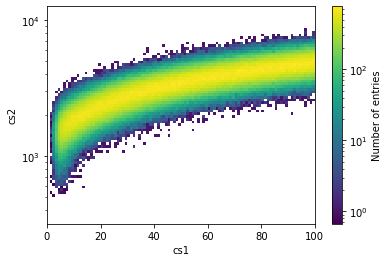

In [14]:
import numpy as np
import multihist as mh
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

hist = mh.Histdd.from_histogram(
    np.array(hist), 
    be, 
    axis_names=['cs1', 'cs2']
)
hist.plot(norm=LogNorm())
plt.yscale('log')
plt.show()

#### Speed test

In [15]:
@apt.utils.timeit
def benchmark():
    key = randgen.get_key()
    for itr in range(100):
        key, _, _ = sim(key, int(1e6))

In [16]:
benchmark()

 Function <benchmark> starts. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 2.512932 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 1.650095 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 16.288996 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.044357 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.541222 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.473511 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.586998 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 21.674156 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.210484 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 19.927979 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.381575 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.659000 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 